
# Casas Benites — São Paulo (Completo) · CDs e Expansão de Lojas com K-Means
**Propósito didático**: notebook completo, sem `geopandas`, para duas decisões distintas:
1) **Localização de Centros de Distribuição (CDs)** para **lojas já existentes**.
2) **Expansão de lojas** usando **população** como peso (demanda esperada).

> Observação: Populações abaixo são **estimativas simplificadas** e servem apenas para fins didáticos.


## Imports e utilitários

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Distância Haversine (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def nearest_city(centroid, df, exclude_existing=False):
    lat, lon = centroid
    dists = haversine(lat, lon, df['lat'].values, df['lon'].values)
    order = np.argsort(dists)
    if not exclude_existing:
        idx = int(order[0])
        row = df.iloc[idx]
        return row['city'], row['state'], float(dists[order[0]])
    # procurar a mais próxima que NÃO seja loja existente
    for idx in order:
        row = df.iloc[int(idx)]
        if not row.get('existing_store', False):
            return row['city'], row['state'], float(dists[int(idx)])
    # fallback: se todas forem existentes, retorna a mais próxima mesmo assim
    idx = int(order[0])
    row = df.iloc[idx]
    return row['city'], row['state'], float(dists[idx])



## Dados de cidades (SP) · lat, lon, população e flag de loja existente
> *Estimativas simplificadas* para fins didáticos. Ajuste conforme necessário.


In [2]:

sp_data = [
    {'city': 'São Paulo', 'state': 'SP', 'lat': -23.5505, 'lon': -46.6333, 'population': 12000000, 'existing_store': True},
    {'city': 'Guarulhos', 'state': 'SP', 'lat': -23.4543, 'lon': -46.5337, 'population': 1400000, 'existing_store': False},
    {'city': 'Osasco', 'state': 'SP', 'lat': -23.532, 'lon': -46.7913, 'population': 700000, 'existing_store': False},
    {'city': 'Santo André', 'state': 'SP', 'lat': -23.6637, 'lon': -46.5383, 'population': 720000, 'existing_store': False},
    {'city': 'São Bernardo do Campo', 'state': 'SP', 'lat': -23.689, 'lon': -46.5646, 'population': 840000, 'existing_store': False},
    {'city': 'Diadema', 'state': 'SP', 'lat': -23.6813, 'lon': -46.62, 'population': 420000, 'existing_store': False},
    {'city': 'Barueri', 'state': 'SP', 'lat': -23.5057, 'lon': -46.879, 'population': 280000, 'existing_store': False},
    {'city': 'Jundiaí', 'state': 'SP', 'lat': -23.1857, 'lon': -46.8978, 'population': 440000, 'existing_store': True},
    {'city': 'Campinas', 'state': 'SP', 'lat': -22.9056, 'lon': -47.0608, 'population': 1300000, 'existing_store': True},
    {'city': 'Americana', 'state': 'SP', 'lat': -22.7377, 'lon': -47.3331, 'population': 240000, 'existing_store': False},
    {'city': 'Limeira', 'state': 'SP', 'lat': -22.565, 'lon': -47.4009, 'population': 310000, 'existing_store': False},
    {'city': 'Piracicaba', 'state': 'SP', 'lat': -22.7338, 'lon': -47.6476, 'population': 410000, 'existing_store': False},
    {'city': 'Rio Claro', 'state': 'SP', 'lat': -22.4111, 'lon': -47.561, 'population': 210000, 'existing_store': False},
    {'city': 'Sorocaba', 'state': 'SP', 'lat': -23.5015, 'lon': -47.4526, 'population': 700000, 'existing_store': True},
    {'city': 'Indaiatuba', 'state': 'SP', 'lat': -23.0907, 'lon': -47.2181, 'population': 270000, 'existing_store': False},
    {'city': 'Itu', 'state': 'SP', 'lat': -23.2665, 'lon': -47.2992, 'population': 180000, 'existing_store': False},
    {'city': 'Itapetininga', 'state': 'SP', 'lat': -23.5917, 'lon': -48.053, 'population': 170000, 'existing_store': False},
    {'city': 'Tatuí', 'state': 'SP', 'lat': -23.3556, 'lon': -47.8569, 'population': 120000, 'existing_store': False},
    {'city': 'Botucatu', 'state': 'SP', 'lat': -22.8859, 'lon': -48.4446, 'population': 150000, 'existing_store': False},
    {'city': 'Bauru', 'state': 'SP', 'lat': -22.3246, 'lon': -49.0871, 'population': 380000, 'existing_store': True},
    {'city': 'Jaú', 'state': 'SP', 'lat': -22.2966, 'lon': -48.5583, 'population': 150000, 'existing_store': False},
    {'city': 'Marília', 'state': 'SP', 'lat': -22.2171, 'lon': -49.9501, 'population': 230000, 'existing_store': False},
    {'city': 'Ourinhos', 'state': 'SP', 'lat': -22.9797, 'lon': -49.8719, 'population': 115000, 'existing_store': False},
    {'city': 'Assis', 'state': 'SP', 'lat': -22.6619, 'lon': -50.4121, 'population': 105000, 'existing_store': False},
    {'city': 'Presidente Prudente', 'state': 'SP', 'lat': -22.1207, 'lon': -51.3925, 'population': 230000, 'existing_store': False},
    {'city': 'Araçatuba', 'state': 'SP', 'lat': -21.206, 'lon': -50.432, 'population': 200000, 'existing_store': False},
    {'city': 'Birigui', 'state': 'SP', 'lat': -21.2887, 'lon': -50.3432, 'population': 120000, 'existing_store': False},
    {'city': 'Penápolis', 'state': 'SP', 'lat': -21.419, 'lon': -50.0773, 'population': 65000, 'existing_store': False},
    {'city': 'Andradina', 'state': 'SP', 'lat': -20.8967, 'lon': -51.3795, 'population': 57000, 'existing_store': False},
    {'city': 'São José do Rio Preto', 'state': 'SP', 'lat': -20.8113, 'lon': -49.3758, 'population': 470000, 'existing_store': True},
    {'city': 'Catanduva', 'state': 'SP', 'lat': -21.1316, 'lon': -48.977, 'population': 120000, 'existing_store': False},
    {'city': 'Barretos', 'state': 'SP', 'lat': -20.5531, 'lon': -48.567, 'population': 120000, 'existing_store': False},
    {'city': 'Franca', 'state': 'SP', 'lat': -20.5386, 'lon': -47.4004, 'population': 370000, 'existing_store': False},
    {'city': 'Ribeirão Preto', 'state': 'SP', 'lat': -21.1775, 'lon': -47.8103, 'population': 720000, 'existing_store': True},
    {'city': 'São Carlos', 'state': 'SP', 'lat': -22.0087, 'lon': -47.8976, 'population': 250000, 'existing_store': False},
    {'city': 'Araraquara', 'state': 'SP', 'lat': -21.7845, 'lon': -48.178, 'population': 240000, 'existing_store': False},
    {'city': 'Mogi das Cruzes', 'state': 'SP', 'lat': -23.5208, 'lon': -46.1855, 'population': 460000, 'existing_store': False},
    {'city': 'Suzano', 'state': 'SP', 'lat': -23.5439, 'lon': -46.311, 'population': 300000, 'existing_store': False},
    {'city': 'Bragança Paulista', 'state': 'SP', 'lat': -22.9527, 'lon': -46.5419, 'population': 180000, 'existing_store': False},
    {'city': 'Atibaia', 'state': 'SP', 'lat': -23.1171, 'lon': -46.5548, 'population': 150000, 'existing_store': False},
    {'city': 'Jacareí', 'state': 'SP', 'lat': -23.2983, 'lon': -45.9658, 'population': 240000, 'existing_store': False},
    {'city': 'São José dos Campos', 'state': 'SP', 'lat': -23.1896, 'lon': -45.8841, 'population': 750000, 'existing_store': True},
    {'city': 'Taubaté', 'state': 'SP', 'lat': -23.0205, 'lon': -45.5569, 'population': 320000, 'existing_store': False},
    {'city': 'Pindamonhangaba', 'state': 'SP', 'lat': -22.9235, 'lon': -45.4614, 'population': 170000, 'existing_store': False},
    {'city': 'Santos', 'state': 'SP', 'lat': -23.959, 'lon': -46.3336, 'population': 430000, 'existing_store': True},
    {'city': 'São Vicente', 'state': 'SP', 'lat': -23.9631, 'lon': -46.3919, 'population': 370000, 'existing_store': False},
    {'city': 'Praia Grande', 'state': 'SP', 'lat': -24.0058, 'lon': -46.402, 'population': 330000, 'existing_store': False}
]
df = pd.DataFrame(sp_data)
print("Total de cidades:", len(df))
df.head()


Total de cidades: 47


,city,state,lat,lon,population,existing_store
0,São Paulo,SP,-23.5505,-46.6333,12000000,True
1,Guarulhos,SP,-23.4543,-46.5337,1400000,False
2,Osasco,SP,-23.5320,-46.7913,700000,False
3,Santo André,SP,-23.6637,-46.5383,720000,False
4,São Bernardo do Campo,SP,-23.6890,-46.5646,840000,False


## Visualização geral (lojas existentes vs. demais cidades)

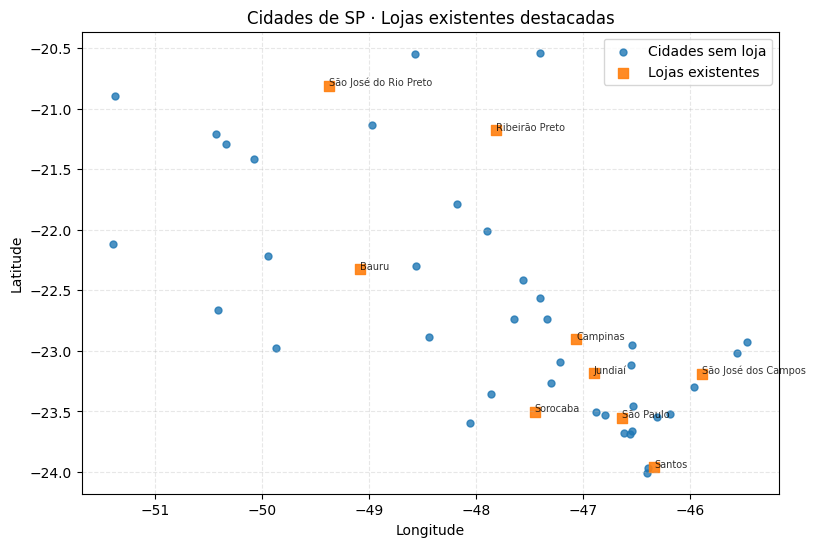

In [3]:

plt.figure(figsize=(9,6))
mask = df['existing_store']
plt.scatter(df.loc[~mask, 'lon'], df.loc[~mask, 'lat'], s=25, alpha=0.8, label='Cidades sem loja')
plt.scatter(df.loc[mask, 'lon'], df.loc[mask, 'lat'], s=60, alpha=0.9, marker='s', label='Lojas existentes')
for _, row in df.iterrows():
    if row['existing_store']:
        plt.annotate(row['city'], (row['lon'], row['lat']), fontsize=7, alpha=0.8)
plt.title("Cidades de SP · Lojas existentes destacadas")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.3); plt.legend()
plt.show()



# Parte A — Localização de **CDs** para **lojas existentes**
**Objetivo**: dado o conjunto de **lojas existentes**, rodar K-Means e sugerir **1, 2 e 3 CDs**.  
Para cada centróide, identificamos a **cidade real mais próxima** (candidata a sede do CD).


In [4]:

df_existing = df[df['existing_store']].copy()
print("Lojas existentes:", len(df_existing))
df_existing[['city','state','lat','lon']].reset_index(drop=True)


Lojas existentes: 9


,city,state,lat,lon
0,São Paulo,SP,-23.5505,-46.6333
1,Jundiaí,SP,-23.1857,-46.8978
2,Campinas,SP,-22.9056,-47.0608
3,Sorocaba,SP,-23.5015,-47.4526
4,Bauru,SP,-22.3246,-49.0871
5,São José do Rio Preto,SP,-20.8113,-49.3758
6,Ribeirão Preto,SP,-21.1775,-47.8103
7,São José dos Campos,SP,-23.1896,-45.8841
8,Santos,SP,-23.9590,-46.3336


In [5]:

def run_cd_scenario(k, df_existing):
    X = df_existing[['lat','lon']].values
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_
    inertia = km.inertia_
    sil = silhouette_score(X, labels) if k > 1 and k < len(X) else float('nan')

    # Plot clusters (apenas lojas existentes)
    plt.figure(figsize=(9,6))
    for i in range(k):
        pts = X[labels == i]
        plt.scatter(pts[:,1], pts[:,0], s=45, alpha=0.9, label=f"Cluster {i+1}")
    plt.scatter(centroids[:,1], centroids[:,0], s=200, marker='X', edgecolor='black', linewidth=1, label="Centróides (CDs)")
    plt.title(f"CDs para lojas existentes — k={k}")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.3); plt.legend()
    plt.show()

    # Cidades candidatas aos CDs (mais próximas dos centróides)
    candidatos = []
    for c in centroids:
        cidade, estado, dist_km = nearest_city(c, df_existing, exclude_existing=False)
        candidatos.append((cidade, estado, dist_km, c[0], c[1]))
    out = pd.DataFrame(candidatos, columns=["cidade_candidata","estado","dist_km","centroid_lat","centroid_lon"])
    display(out.sort_values("dist_km"))
    print(f"Inércia (WCSS): {inertia:.2f} | Silhouette: {sil:.3f}")
    return centroids, labels, inertia, sil


### k = 1 (um CD)

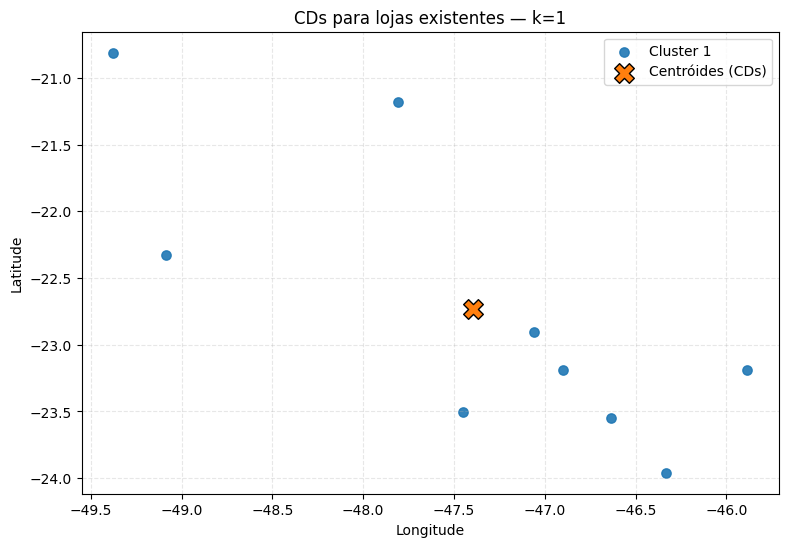

,cidade_candidata,estado,dist_km,centroid_lat,centroid_lon
0,Campinas,SP,39.018223,-22.733922,-47.392822


Inércia (WCSS): 20.80 | Silhouette: nan


In [6]:
cA1 = run_cd_scenario(1, df_existing)

### k = 2 (dois CDs)

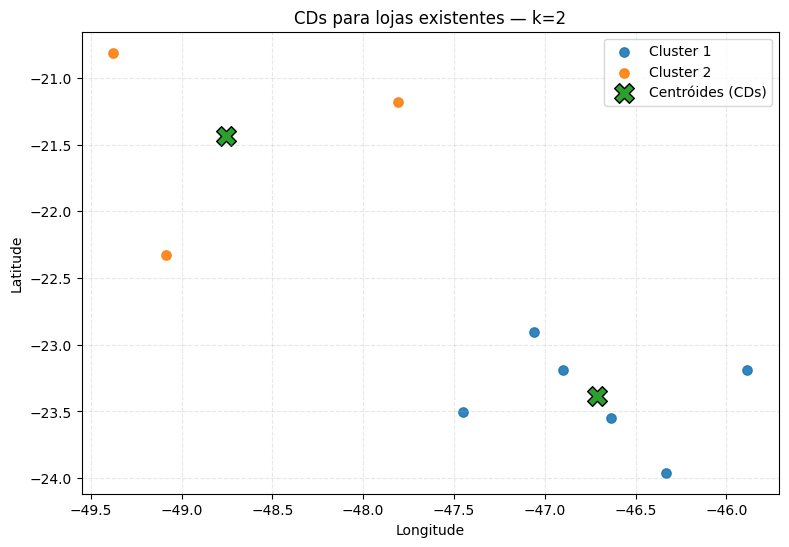

,cidade_candidata,estado,dist_km,centroid_lat,centroid_lon
0,São Paulo,SP,20.320197,-23.381983,-46.710367
1,São José do Rio Preto,SP,94.671643,-21.437800,-48.757733


Inércia (WCSS): 4.85 | Silhouette: 0.608


In [7]:
cA2 = run_cd_scenario(2, df_existing)

### k = 3 (três CDs)

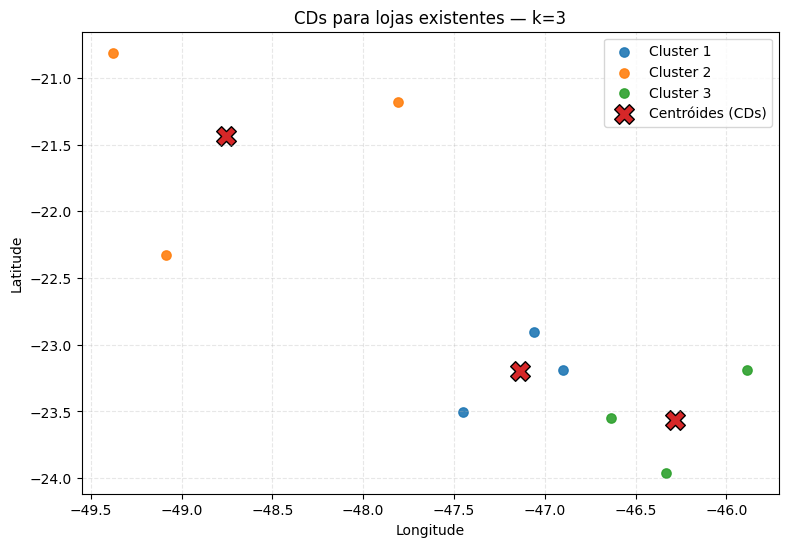

,cidade_candidata,estado,dist_km,centroid_lat,centroid_lon
0,Jundiaí,SP,24.491112,-23.197600,-47.137067
2,São Paulo,SP,35.680768,-23.566367,-46.283667
1,São José do Rio Preto,SP,94.671643,-21.437800,-48.757733


Inércia (WCSS): 3.56 | Silhouette: 0.344


In [8]:
cA3 = run_cd_scenario(3, df_existing)


# Parte B — **Expansão de lojas** com **população** (pesos)
**Objetivo**: usar **todas as cidades** e aplicar **K-Means ponderado pela população** para sugerir **novas lojas** (clusters de demanda).  
Para cada centróide, sugerimos a **cidade não atendida** mais próxima (se possível).


In [9]:

def run_weighted_expansion(k, df_full):
    X = df_full[['lat','lon']].values
    w = df_full['population'].values.astype(float)
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X, sample_weight=w)
    centroids = km.cluster_centers_
    inertia = km.inertia_

    # silhouette sem peso (aprox.) — apenas para referência
    sil = silhouette_score(X, labels) if k > 1 and k < len(X) else float('nan')

    # Plot: cidades sem loja (oportunidade) vs existentes
    plt.figure(figsize=(9,6))
    mask = df_full['existing_store']
    plt.scatter(df_full.loc[~mask,'lon'], df_full.loc[~mask,'lat'], s=20, alpha=0.8, label="Cidades sem loja")
    plt.scatter(df_full.loc[mask,'lon'], df_full.loc[mask,'lat'], s=60, alpha=0.9, marker='s', label="Lojas existentes")
    plt.scatter(centroids[:,1], centroids[:,0], s=220, marker='X', edgecolor='black', linewidth=1, label="Centróides (demanda)")
    plt.title(f"Clusters de demanda (população) — k={k}")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.3); plt.legend()
    plt.show()

    # Sugerir cidades candidatas (preferindo não existentes)
    candidatos = []
    for c in centroids:
        cidade, estado, dist_km = nearest_city(c, df_full, exclude_existing=True)
        candidatos.append((cidade, estado, dist_km, c[0], c[1]))
    out = pd.DataFrame(candidatos, columns=["cidade_candidata_nova_loja","estado","dist_km","centroid_lat","centroid_lon"])
    display(out.sort_values("dist_km"))
    print(f"Inércia (WCSS): {inertia:.2f} | Silhouette (aprox. sem peso): {sil:.3f}")
    return centroids, labels, inertia, sil


### k = 1 (uma nova loja)

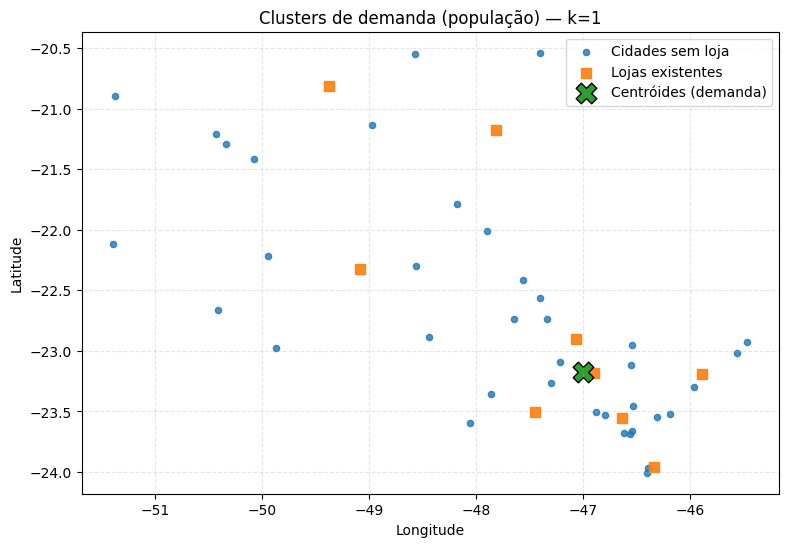

,cidade_candidata_nova_loja,estado,dist_km,centroid_lat,centroid_lon
0,Indaiatuba,SP,24.460098,-23.176075,-46.997642


Inércia (WCSS): 43793104.00 | Silhouette (aprox. sem peso): nan


In [10]:
cB1 = run_weighted_expansion(1, df)

### k = 2 (duas novas lojas)

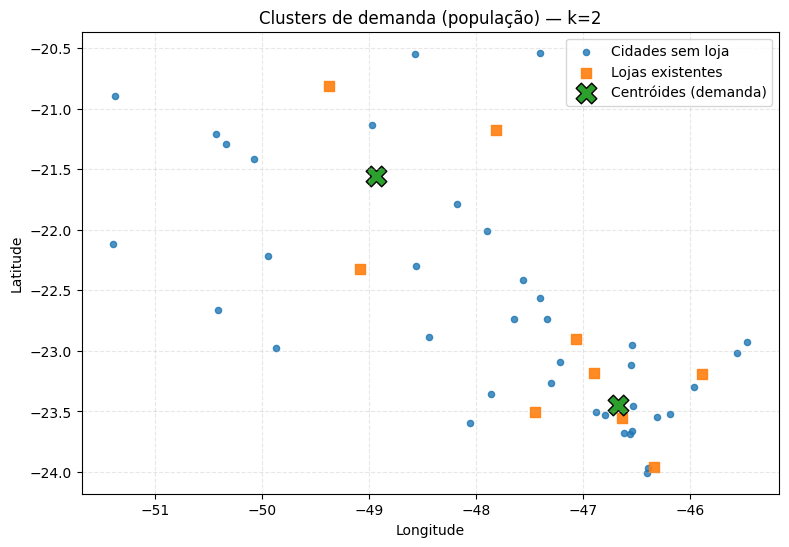

,cidade_candidata_nova_loja,estado,dist_km,centroid_lat,centroid_lon
0,Guarulhos,SP,14.133129,-23.447099,-46.672023
1,Catanduva,SP,47.715256,-21.559332,-48.940054


Inércia (WCSS): 13277074.35 | Silhouette (aprox. sem peso): 0.570


In [11]:
cB2 = run_weighted_expansion(2, df)

### k = 3 (três novas lojas)

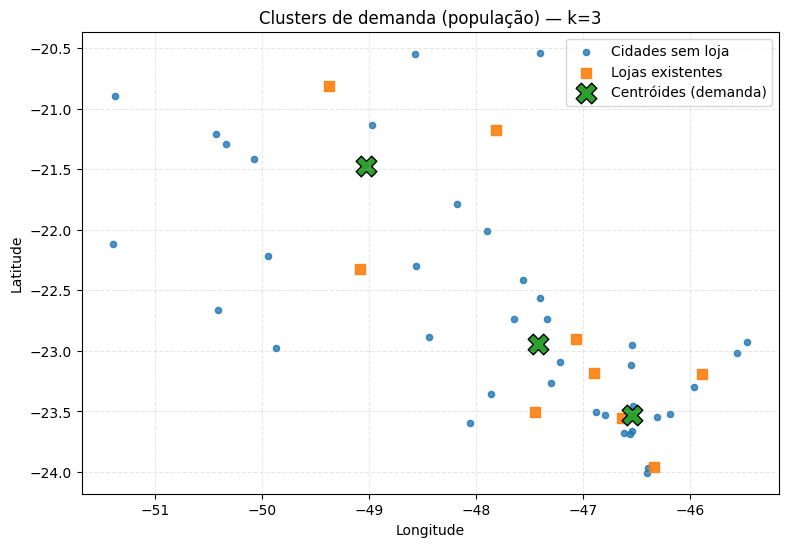

,cidade_candidata_nova_loja,estado,dist_km,centroid_lat,centroid_lon
0,Guarulhos,SP,8.652745,-23.531720,-46.542249
2,Americana,SP,24.441600,-22.941647,-47.422060
1,Catanduva,SP,38.589280,-21.475007,-49.030772


Inércia (WCSS): 9991004.78 | Silhouette (aprox. sem peso): 0.409


In [12]:
cB3 = run_weighted_expansion(3, df)

### k = 4 (quatro novas lojas)

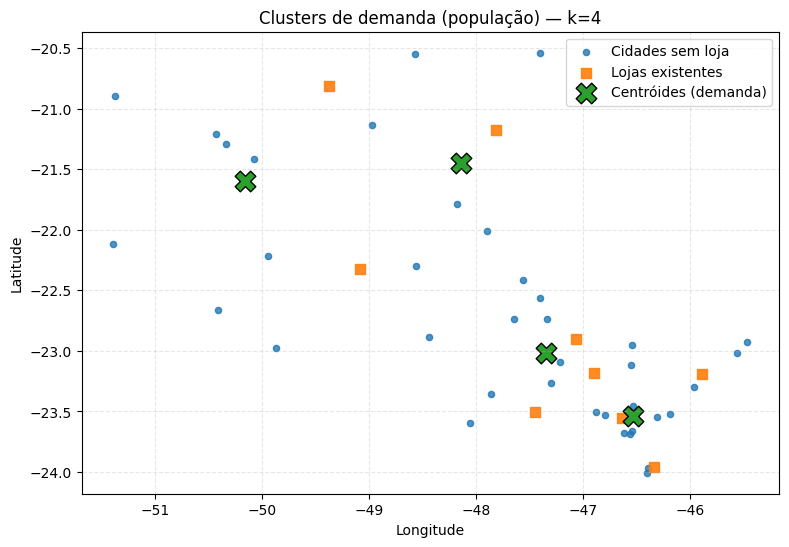

,cidade_candidata_nova_loja,estado,dist_km,centroid_lat,centroid_lon
0,Guarulhos,SP,9.452959,-23.539310,-46.534450
2,Indaiatuba,SP,15.279902,-23.017340,-47.344380
3,Penápolis,SP,21.443000,-21.595704,-50.160303
1,Araraquara,SP,37.348745,-21.450017,-48.145024


Inércia (WCSS): 6193135.00 | Silhouette (aprox. sem peso): 0.425


In [13]:
cB3 = run_weighted_expansion(4, df)

### k = 5 (cinco novas lojas)

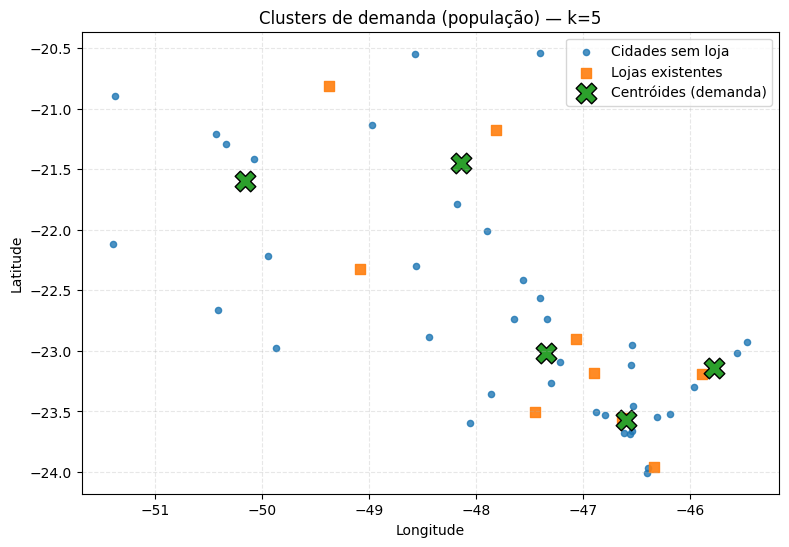

,cidade_candidata_nova_loja,estado,dist_km,centroid_lat,centroid_lon
0,Santo André,SP,11.790664,-23.571109,-46.594701
2,Indaiatuba,SP,15.279902,-23.017340,-47.344380
3,Penápolis,SP,21.443000,-21.595704,-50.160303
4,Jacareí,SP,26.029750,-23.140099,-45.778049
1,Araraquara,SP,37.348745,-21.450017,-48.145024


Inércia (WCSS): 5024260.98 | Silhouette (aprox. sem peso): 0.412


In [14]:
cB3 = run_weighted_expansion(5, df)


## (Opcional) Varredura de k e comparação
Use os blocos abaixo para comparar métricas e discutir **trade-offs**:  
- CDs: cobertura de lojas existentes.
- Expansão: captação de demanda populacional.


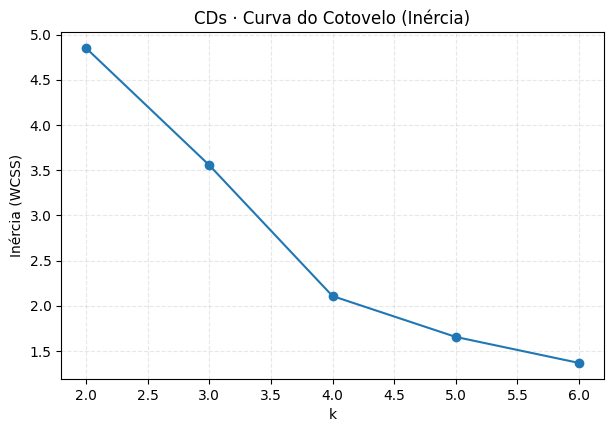

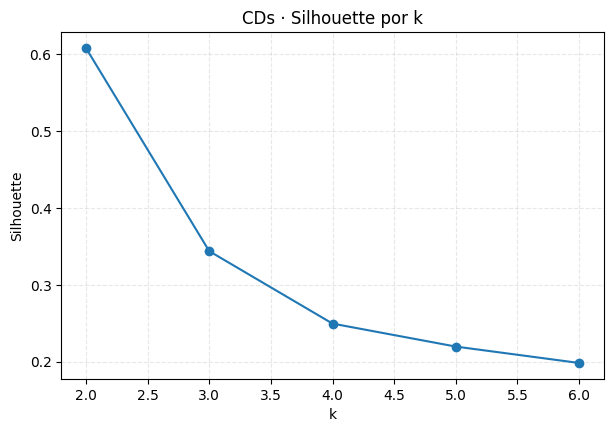

In [15]:

# Varredura de k para CDs (lojas existentes)
ks = list(range(2, 7))
X_exist = df_existing[['lat','lon']].values
inertias_cd, sil_cd = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X_exist)
    inertias_cd.append(km.inertia_)
    sil_cd.append(silhouette_score(X_exist, labels))

fig, ax = plt.subplots(figsize=(7,4.5))
ax.plot(ks, inertias_cd, marker='o')
ax.set_title("CDs · Curva do Cotovelo (Inércia)")
ax.set_xlabel("k"); ax.set_ylabel("Inércia (WCSS)")
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(7,4.5))
ax.plot(ks, sil_cd, marker='o')
ax.set_title("CDs · Silhouette por k")
ax.set_xlabel("k"); ax.set_ylabel("Silhouette")
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()


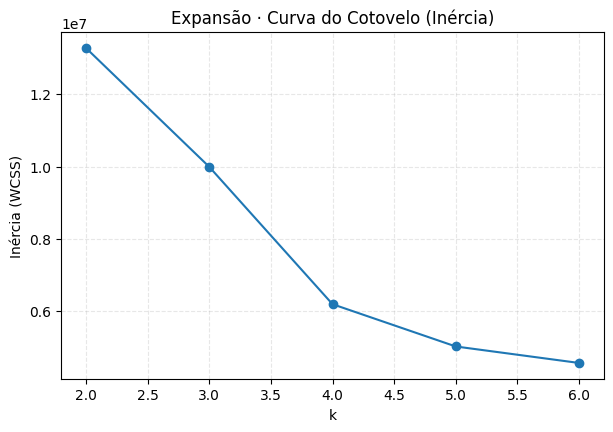

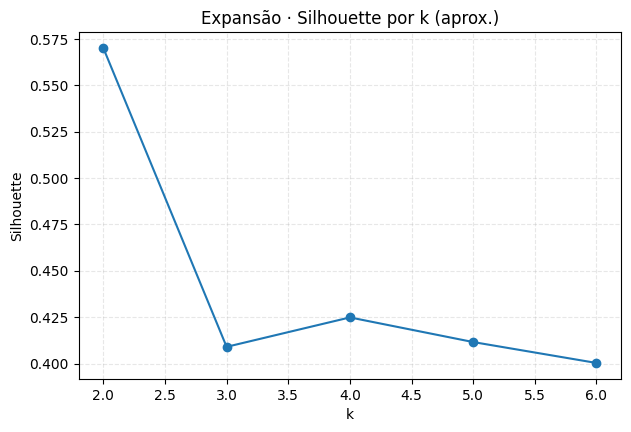

In [16]:

# Varredura de k para Expansão (ponderado por população)
ks = list(range(2, 7))
X_full = df[['lat','lon']].values
w = df['population'].values.astype(float)
inertias_exp, sil_exp = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = km.fit_predict(X_full, sample_weight=w)
    inertias_exp.append(km.inertia_)
    # Silhouette sem peso (aprox.)
    from sklearn.metrics import silhouette_score
    sil_exp.append(silhouette_score(X_full, labels))

fig, ax = plt.subplots(figsize=(7,4.5))
ax.plot(ks, inertias_exp, marker='o')
ax.set_title("Expansão · Curva do Cotovelo (Inércia)")
ax.set_xlabel("k"); ax.set_ylabel("Inércia (WCSS)")
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(7,4.5))
ax.plot(ks, sil_exp, marker='o')
ax.set_title("Expansão · Silhouette por k (aprox.)")
ax.set_xlabel("k"); ax.set_ylabel("Silhouette")
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()
